In [3]:
%load_ext Cython

import cython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
# %matplotlib inline

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [4]:
from scipy.stats import cauchy
import scipy.stats as stats 
import arviz as az
from JSAnimation import IPython_display
import pymc3 as pm
import theano as thea
import theano.tensor as tt
%matplotlib inline

In [5]:
def gaussian(x, a, t0, sigma, y_intercept):
    
    return -1*a * np.exp(-1*(((x-t0)**2)/(2*sigma**2)))+y_intercept

In [6]:
np.random.seed(23)

In [7]:
df = pd.read_excel('./../Data/lc.xlsx')

In [8]:
# Choosing a filter from the list of filters: [V , R, B]
filt = 'V'

#selecting a higher and lower limit for the fraction of the light curve including the minima
low_lim = 150
up_lim =200

#Selecting the portion of the light curve including the minima
x = df['time_'+filt].values[low_lim:up_lim]-2.4588252e6
y = df['rel_f_'+filt].values[low_lim:up_lim]
yerr = df['rel_f_'+filt+'_err'].values[low_lim:up_lim] 

No handles with labels found to put in legend.


Text(0, 0.5, 'Relative Flux')

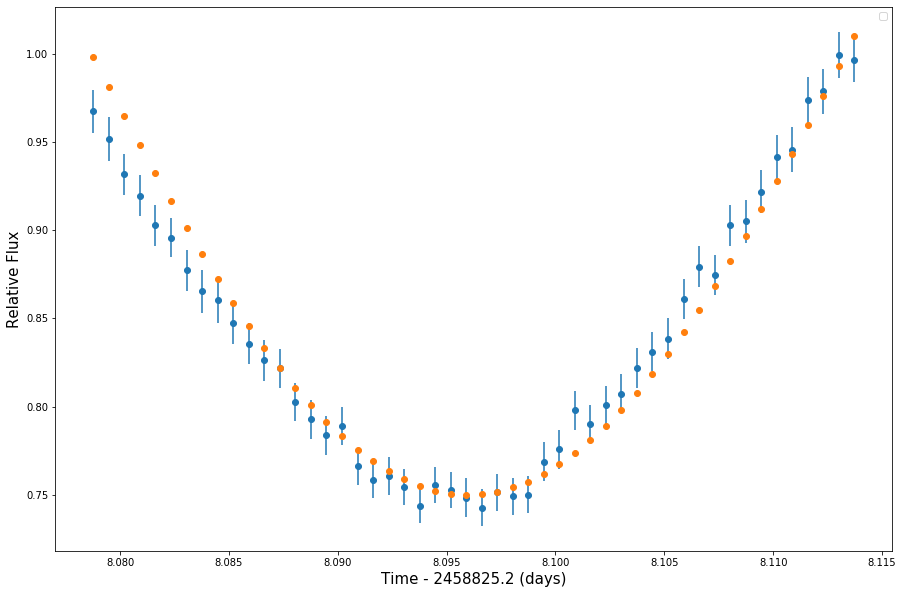

In [9]:
fig = plt.figure(figsize=(15,10))


plt.errorbar(x,y, yerr, fmt='o')

plt.errorbar(x,gaussian(x, 0.8, 8.096, 0.02, 1.55), fmt='o')

plt.legend()
plt.xlabel('Time - 2458825.2 (days)', size = 15)
plt.ylabel('Relative Flux', size =15)

In [12]:
nsample = 1000

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    a = pm.Uniform('a', lower=0.5, upper=1.)
    t0 = pm.Uniform('t0', lower=8.085, upper=7.05)
    sigma = pm.Uniform('sigma', lower=0.01, upper=0.03)
    y_i = pm.Uniform('y_intercept', lower = 1, upper = 2)

    # Define likelihood
    likelihood = pm.Normal('y', mu= -1*a*np.exp(-1*(((x-t0)**2)/(2*sigma**2)))+y_i, \
                        sd=yerr, observed=y)
     
    # Inference
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS() # Instantiate MCMC sampling algorithm
    trc_studentt = pm.sample(nsample, step, start=start, progressbar=True) # run with 4 cores

az.plot_trace(trc_studentt);

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_intercept, sigma, t0, a]


Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
t0_interval__   NaN
y               NaN


ParallelSamplingError: Bad initial energy

In [345]:
az.summary(trc_studentt, round_to=5)

/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz.stats.stats_utils - WARNING - Array contains NaN-value.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.75,0.0,0.75,0.75,0.0,0.0,4000.0,4000.0,4000.0,4000.0,NaN
t0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sigma,0.02,0.0,0.02,0.02,0.0,0.0,4000.0,4000.0,4000.0,4000.0,NaN
y_intercept,1.05,0.0,1.05,1.05,0.0,0.0,4000.0,4000.0,4000.0,4000.0,NaN


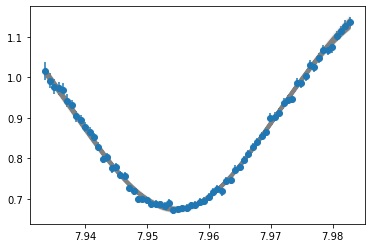

In [311]:
### Plot the predictive posterior samples
plt.errorbar(x, y, yerr,fmt='o', label='data')
for a_, b_, c_, d_ in zip(trc_studentt['a'][-500:], trc_studentt['t0'][-500:], trc_studentt['sigma'][-500:], trc_studentt['y_intercept'][-500:]):
    plt.plot(x, -1*a_*np.exp(-1*(((x-b_)**2)/(2*c_**2)))+d_, c='gray', alpha=0.1)

In [312]:
print ('t0 is '+str(az.summary(trc_studentt, round_to=5)['mean'].t0+2.4588252e6))
print ('Uncertainty in t0 is '+str(az.summary(trc_studentt, round_to=5)['sd'].t0))

/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


t0 is 2458833.15474


/Users/somayeh/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Uncertainty in t0 is 9e-05
